In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

def compute_bDPI(df, n_clusters):
    """
    Compute Balanced Discriminative Power Index (bDPI) for a matrix:
    rows = clusters
    columns = features/pathways
    values = -log10(p-values)
    """
    cols = df.columns.tolist()

    for i in range(n_clusters):
        if str(i) not in cols:
            print(f"Cluster {i} is missing from the columns.")
            df[str(i)] = 0
            
    df = df.T
    # -----------------------
    # Load data
    # -----------------------

    X = df.values  # clusters x features
    K, F = X.shape

    # -----------------------
    # Step 1: Feature discriminativity (1 - normalized entropy)
    # -----------------------
    # Compute p_i per feature (normalize across clusters)
    X_sum = X.sum(axis=0, keepdims=True)
    
    # Avoid division by zero (features with all zero enrichment)
    X_sum[X_sum == 0] = 1
    P = X / X_sum

    # Entropy per feature
    H = entropy(P + 1e-12, axis=0)     # + tiny constant for stability

    # Normalized entropy
    H_norm = H / np.log(K)

    # Discriminativity score
    D_f = 1 - H_norm  # vector of length F

    # Average discriminativity
    D_mean = np.mean(D_f)

    # -----------------------
    # Step 2: Assign each feature to its "best cluster"
    # -----------------------
    best_clusters = np.argmax(X, axis=0)  # length F

    # Count how many features assigned to each cluster
    C = np.bincount(best_clusters, minlength=K)

    # -----------------------
    # Step 3: Cluster balance
    # -----------------------
    C_sum = C.sum()
    if C_sum == 0:
        # No discriminative features at all
        return 0.0

    P_C = C / C_sum  # distribution across clusters

    # Cluster entropy
    Hc = entropy(P_C + 1e-12)

    # Normalized cluster entropy
    Hc_norm = Hc / np.log(K)

    # Balance score (1 = perfectly even distribution)
    Balance = 1 - Hc_norm

    # -----------------------
    # Step 4: Feature quantity score
    # -----------------------
    Q = np.log(1 + F)

    # -----------------------
    # Step 5: Final bDPI
    # -----------------------
    

    return D_mean, Balance, Q


# -----------------------
# Example usage
# -----------------------

# score = compute_bDPI("my_matrix.csv")
# print("bDPI score:", score)
import numpy as np
import pandas as pd
from scipy.stats import entropy

def compute_discriminative_metrics(df, n_clusters, threshold=0.8, min_features_per_cluster=1):
    """
    Computes simple metrics focused on discriminative features.
    rows = clusters
    columns = features
    values = -log10(p-values)
    threshold = CS threshold to classify as discriminative
    """

    cols = df.columns.tolist()

    for i in range(n_clusters):
        if str(i) not in cols:
            print(f"Cluster {i} is missing from the columns.")
            df[str(i)] = 0
            
    df = df.T
    
    X = df.values
    K, F = X.shape

    # Normalize across clusters
    X_sum = X.sum(axis=0, keepdims=True)
    X_sum[X_sum == 0] = 1
    P = X / X_sum

    # Compute cluster specificity (CS)
    H = entropy(P + 1e-12, axis=0)
    CS = 1 - H / np.log(K)

    # Classify discriminative features
    disc_mask = CS >= threshold
    n_disc = disc_mask.sum()

    # Metrics
    DFR = n_disc / F
    
    # Mean number of discriminative features per cluster (including clusters with 0)
    if n_disc > 0:
        best_clusters = np.argmax(X[:, disc_mask], axis=0)
        C = np.bincount(best_clusters, minlength=K)
        # Divide by total number of clusters (K) to include clusters with 0 pathways
        mean_disc_per_cluster = n_disc / K
    else:
        mean_disc_per_cluster = 0
        
        # Soft completeness
    # --------------------------
    # Assign each feature to its "best" cluster
    best_cluster = np.argmax(X, axis=0)
    disc_best = best_cluster[disc_mask]   # clusters for discriminative features

    # Count discriminative features per cluster
    counts = np.bincount(disc_best, minlength=K)

    # % clusters with at least min_features_per_cluster discriminative features
    completeness = np.sum(counts >= min_features_per_cluster) / K

    

    return {
        "DFR": DFR,
        "n_disc": n_disc,
        "mean_disc_per_cluster": mean_disc_per_cluster,
        "completeness": completeness
    }

In [2]:
import os
import glob
import json

with open("../../config/config_notebooks_HER2.json", "r") as config_file:
    config = json.load(config_file)
    


In [3]:
config["retrained_model_list1"]

['uni',
 'uni_explora_kde_4096_prototypes',
 'uni_explora_kde_16384_prototypes',
 'uni_explora_kde_65536_prototypes',
 'uni_explora_koleo_4096_prototypes',
 'uni_explora_koleo_16384_prototypes',
 'uni_explora_koleo_65536_prototypes']

In [9]:
results = {}
opti_clusters_dict = {}

for folder, names in zip(
    [config["retrained_benchmark_folder1"],
     config["retrained_benchmark_folder2"]],
    [config["retrained_model_list1"],
     config["retrained_model_list2"]],
):


        
    path_ = os.path.join(folder, "invasive_cancer_clustering", "kmeans")
    opti_clusters = pd.read_csv(os.path.join(path_, "opti_clusters.csv"))
    for name in names:
        if not (name == "uni" and "full" in folder):
            path = f"{path_}/{name}"
            n = opti_clusters.loc[opti_clusters["name"] == name, "n_clusters"].values[0]
            # n = 7
            print(f"Processing model: {name} with {n} clusters")
            df = pd.read_csv(os.path.join(path, f"upregulated_{n}_clusters_all_result_matrix_no_labels.csv"), index_col=0)
            results[name] = compute_discriminative_metrics(df, n, min_features_per_cluster=5)
            opti_clusters_dict[name] = n


Processing model: uni with 7 clusters
Processing model: uni_explora_kde_4096_prototypes with 9 clusters
Processing model: uni_explora_kde_16384_prototypes with 8 clusters
Cluster 3 is missing from the columns.
Cluster 5 is missing from the columns.
Processing model: uni_explora_kde_65536_prototypes with 9 clusters
Cluster 5 is missing from the columns.
Processing model: uni_explora_koleo_4096_prototypes with 9 clusters
Cluster 0 is missing from the columns.
Processing model: uni_explora_koleo_16384_prototypes with 9 clusters
Processing model: uni_explora_koleo_65536_prototypes with 8 clusters
Processing model: uni_full_kde_4096_prototypes with 9 clusters
Cluster 0 is missing from the columns.
Processing model: uni_full_kde_16384_prototypes with 8 clusters
Cluster 6 is missing from the columns.
Processing model: uni_full_kde_65536_prototypes with 6 clusters
Cluster 1 is missing from the columns.
Processing model: uni_full_koleo_4096_prototypes with 6 clusters
Processing model: uni_full_

In [10]:
df_res = pd.DataFrame(results).T

In [11]:
df_res

,DFR,n_disc,mean_disc_per_cluster,completeness
uni,0.472222,51.0,7.285714,0.428571
uni_explora_kde_4096_prototypes,0.443478,51.0,5.666667,0.444444
uni_explora_kde_16384_prototypes,0.470000,47.0,5.875000,0.250000
uni_explora_kde_65536_prototypes,0.403846,42.0,4.666667,0.333333
uni_explora_koleo_4096_prototypes,0.345794,37.0,4.111111,0.444444
uni_explora_koleo_16384_prototypes,0.398374,49.0,5.444444,0.444444
uni_explora_koleo_65536_prototypes,0.418182,46.0,5.750000,0.500000
uni_full_kde_4096_prototypes,0.400000,42.0,4.666667,0.222222
uni_full_kde_16384_prototypes,0.500000,45.0,5.625000,0.500000
uni_full_kde_65536_prototypes,0.693182,61.0,10.166667,0.666667


In [12]:


import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])


df_res = df_res.loc[sorted_models]



In [13]:
palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

/tmp/ipykernel_984115/2392345939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x=df_res.index,
/tmp/ipykernel_984115/2392345939.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x=df_res.index,


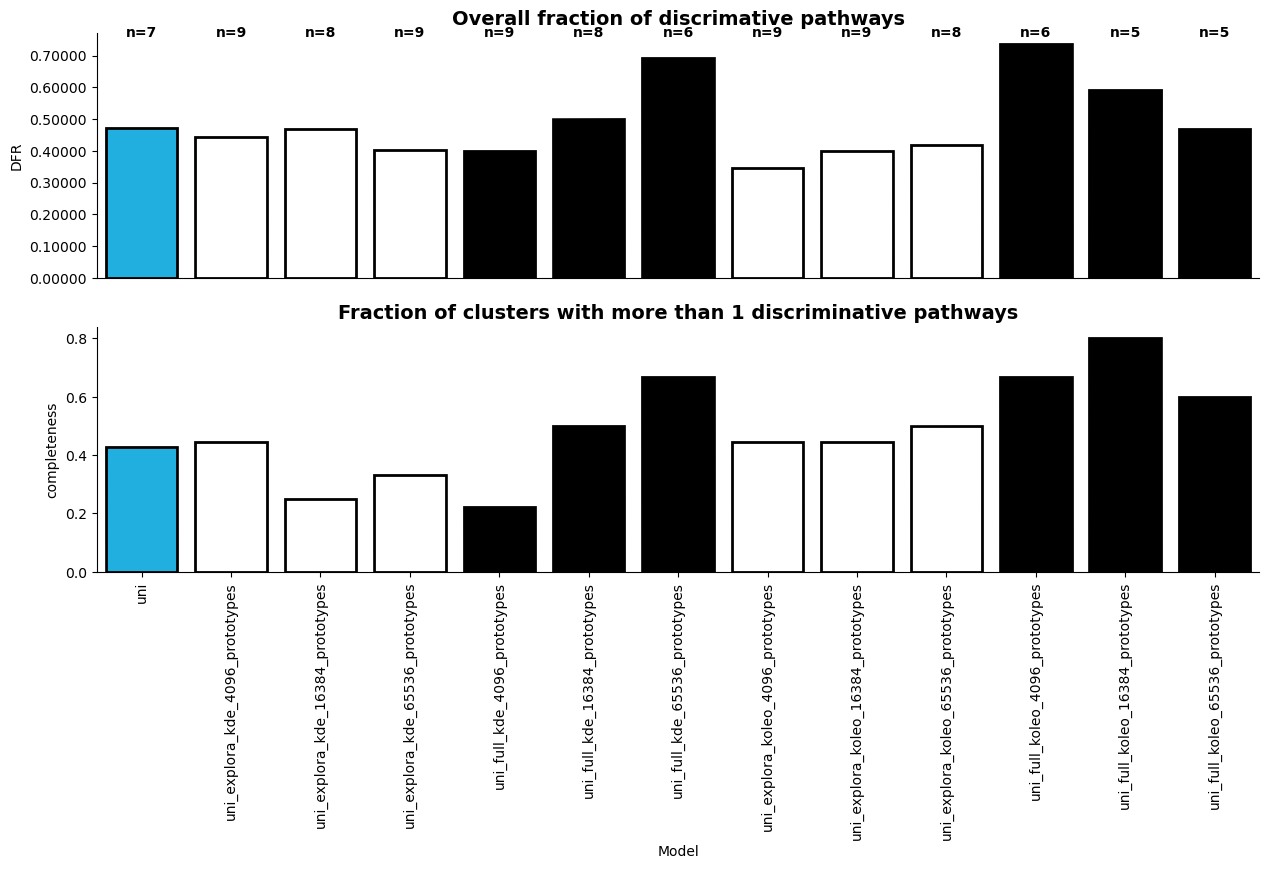

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
sns.barplot(data=df_res, x=df_res.index, 
            y="DFR", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("DFR")
plt.xlabel("")
plt.title(f"Overall fraction of discrimative pathways", weight="bold", fontsize=14)
plt.xticks([])
sns.despine()
for i, model_name in enumerate(df_res.index):
    plt.text(x=i, y=0.75, s=f"n={opti_clusters_dict[model_name]}", ha='center', va='bottom', weight='bold')


plt.subplot(2, 1, 2)
sns.barplot(data=df_res, x=df_res.index, 
            y="completeness", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("completeness")
plt.xlabel("Model")
plt.title(f"Fraction of clusters with more than 1 discriminative pathways", weight="bold", fontsize=14)
sns.despine()








/tmp/ipykernel_984115/2015825963.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x=df_res.index,


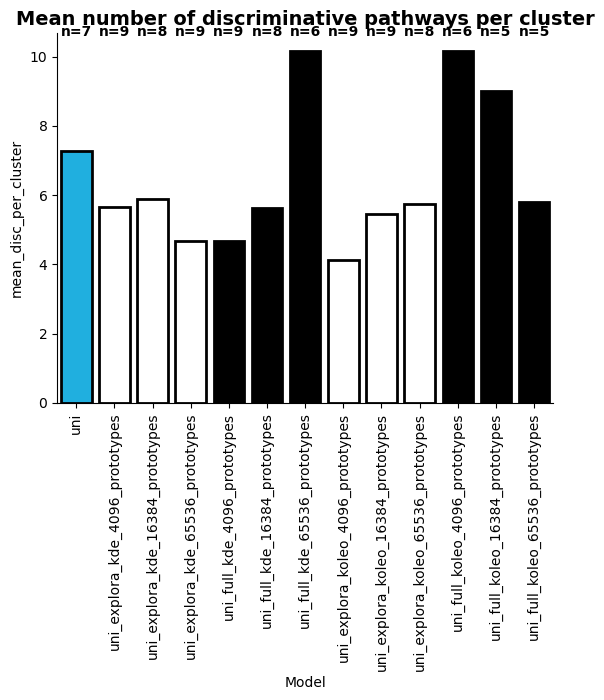

In [16]:
sns.barplot(data=df_res, x=df_res.index, 
            y="mean_disc_per_cluster", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("mean_disc_per_cluster")
plt.xlabel("Model")
plt.title(f"Mean number of discriminative pathways per cluster", weight="bold", fontsize=14)
sns.despine()

for i, model_name in enumerate(df_res.index):
    plt.text(x=i, y=10.5, s=f"n={opti_clusters_dict[model_name]}", ha='center', va='bottom', weight='bold')
